In the traditional machine learning domain, building robust and meaningful features can significantly improve final model performance. As a result, in this notebook, I intend to demonstrate the capability of this package on the automated future construction. For the sake of simplicity, I chose a problem from the scikit-learn package as the case study problem. The task is called "diabetes," and its goal is to predict a quantitative measure of disease progression one year after baseline. First, we split the data into a training and a testing set, then train a random forest and an evolutionary forest separately and test them on the testing set.


In [35]:
import random

import numpy as np

from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append
from evolutionary_forest.forest import cross_val_score, EvolutionaryForestRegressor

random.seed(0)
np.random.seed(0)

X, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
r = RandomForestRegressor()
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))
r = EvolutionaryForestRegressor(max_height=8, normalize=True, select='AutomaticLexicase',
                                mutation_scheme='weight-plus-cross-global',
                                gene_num=10, boost_size=100, n_gen=100, base_learner='DT',
                                verbose=True)
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

0.26491330931789137
   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min      	nevals	std     	avg  	gen	max	min	nevals	std    
0  	50    	0.123885	0  	0.537842	-0.126433	50    	0.135692	42.68	0  	58 	32 	50    	5.27045
1  	50    	0.0770607	1  	0.341941	-0.179468	50    	0.117896	42.48	1  	54 	34 	50    	4.57051
2  	50    	0.0367042	2  	0.263943	-0.140117	50    	0.0960126	43.8 	2  	54 	32 	50    	4.5299 
3  	50    	0.0288158	3  	0.235371	-0.21743 	50    	0.0954819	42.56	3  	54 	34 	50    	5.20062
4  	50    	0.00906959	4  	0.174993	-0.152483	50    	0.0801536	41.84	4  	52 	34 	50    	4.81398
5  	50    	-0.0177332	5  	0.149236	-0.171106	50    	0.0815517	43.92	5  	54 	34 	50    	4.59495
6  	50    	-0.0358982	6  	0.152073	-0.198653	50    	0.0769967

Based on this result, we can see that the evolutionary forest outperforms the traditional random forest. However, we should not be satisfied with simply having a better model. In fact, a more important goal is to obtain more explainable features, which can improve the performance of many machine learning models. As a result, in the section that follows, we calculate our future importance based on impurity reduction and then rank all features based on those importance scores. For clarity, our package will only display the top 15 most important features.


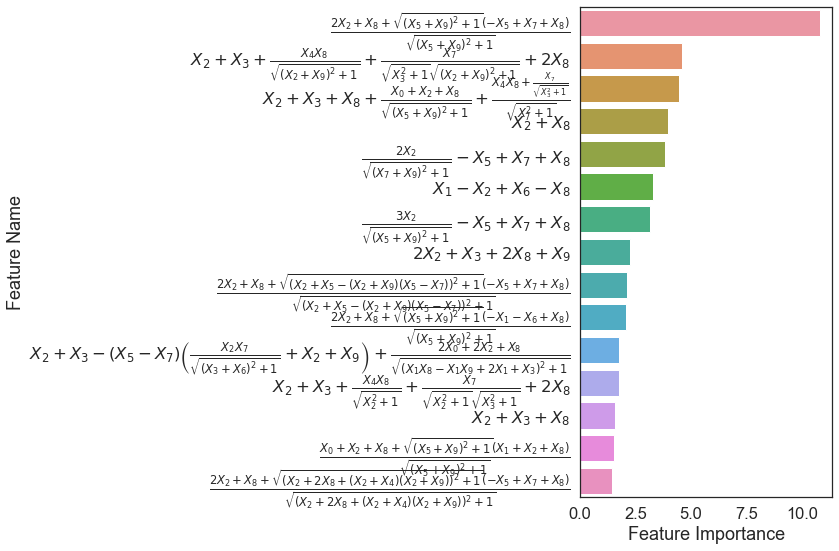

In [36]:
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

Following the creation of the importance map, we may be able to leverage those useful features in the following section and investigate whether those features can truly improve the performance of an existing model. For the sake of simplicity, we abandoned the use of the original features and only retained the constructed features.

In [37]:
code_importance_dict = get_feature_importance(r, simple_version=False)
new_X = feature_append(r, X, list(code_importance_dict.keys())[:20], only_new_features=True)
new_train = feature_append(r, x_train, list(code_importance_dict.keys())[:20], only_new_features=True)
new_test = feature_append(r, x_test, list(code_importance_dict.keys())[:20], only_new_features=True)
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

0.2865161546726096


As we can see from the results, the constructed features can truly lead to improved performance, demonstrating the effectiveness of constructed features. However, a more interesting question is whether these features can only be used on this model or if they can also be applied to other machine learning models. So, in the following section, we try to see if these features can be used to improve the performance of existing state-of-the-art machine learning systems.

In [38]:
regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM', 'CatBoost']

scores_base = []
scores = []

for regr in regressor_list:
    regressor = {
        'RF': RandomForestRegressor(n_jobs=1, n_estimators=100),
        'ET': ExtraTreesRegressor(n_estimators=100),
        'AdaBoost': AdaBoostRegressor(n_estimators=100),
        'GBDT': GradientBoostingRegressor(n_estimators=100),
        'DART': LGBMRegressor(n_jobs=1, n_estimators=100, boosting_type='dart'),
        'XGBoost': XGBRegressor(n_jobs=1, n_estimators=100),
        'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=100),
        'CatBoost': CatBoostRegressor(n_estimators=100, thread_count=1,
                                      verbose=False, allow_writing_files=False),
    }[regr]
    score = cross_val_score(regressor, X, y)
    print(regr, score, np.mean(score))
    scores_base.append(np.mean(score))
    score = cross_val_score(regressor, new_X, y)
    print(regr, score, np.mean(score))
    scores.append(np.mean(score))
scores_base = np.array(scores_base)
scores = np.array(scores)

RF [0.40687788 0.48232282 0.44269645 0.35267621 0.44181526] 0.4252777225424557
RF [0.50793898 0.53050996 0.52949131 0.42782289 0.48283776] 0.4957201806972883
ET [0.36793279 0.5021531  0.4315543  0.40709356 0.45861526] 0.43346980380606287
ET [0.46677294 0.51676178 0.51322419 0.40318946 0.46436162] 0.4728619983346178
AdaBoost [0.37194555 0.45511817 0.41798425 0.41877328 0.42923058] 0.4186103652544749
AdaBoost [0.3823143  0.51884104 0.45531521 0.41891795 0.45295098] 0.44566789858668293
GBDT [0.3369759  0.51456239 0.42577374 0.33095893 0.4255554 ] 0.40676527219349135
GBDT [0.48299994 0.47270435 0.53152066 0.43823941 0.45024527] 0.4751419254707957
DART [0.35379204 0.4339262  0.40526565 0.29617651 0.40656592] 0.37914526592589093
DART [0.49346642 0.45434591 0.51810906 0.38240628 0.45425024] 0.4605155806458937
XGBoost [0.19069273 0.31696014 0.38186465 0.15942315 0.30005706] 0.2697995450013659
XGBoost [0.45217748 0.45463161 0.41229883 0.26416623 0.38149529] 0.3929538866861097
LightGBM [0.354635

As a result of this, we can conclude that constructive features improve the performance of all models. It specifically improves the performance of XGBoost and random forest. As a result of this experiment, we can conclude that our method can be used not only as an effective regression method for inducing a powerful regression model, but also as a feature construction method, which can be used to generate interpretable features and improve the performance of existing machine learning systems. The improvement caused by construction features is depicted in the figure below.

['g' 'g' 'g' 'g' 'g' 'g' 'g' 'g']


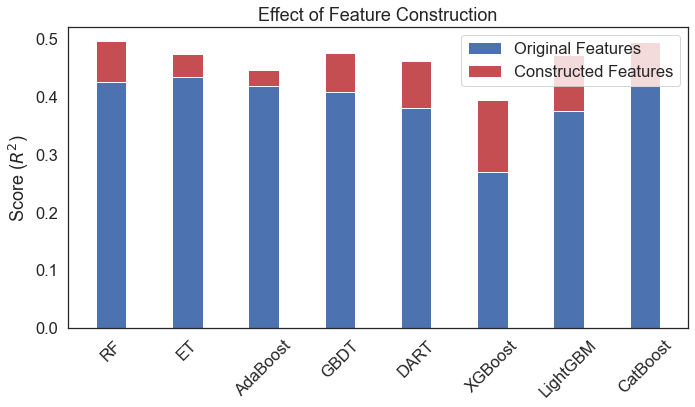

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(regressor_list, scores_base, width, label='Original Features')
difference = scores - scores_base
print(np.where(difference > 0, 'g', 'y'))
ax.bar(regressor_list, difference, width, bottom=scores_base,
       label='Constructed Features',
       color=np.where(difference > 0, 'r', 'y'))
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we have shown that our method is capable of discovering useful features that can be used to improve existing machine learning systems. It should be noted, however, that even if the discovered features improve the validation score, there is a risk of overfitting. As a result, in real-world applications, we should validate the obtained model on hold-out testing data to ensure the effectiveness of the newly constructed model.